# Census Population Data (2020) + NYC Tree Census Data (2015)

### Tress per capita (by Census Tract) 

### BRONX

In [126]:
# load libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pysal as ps
import libpysal
import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import plot_local_autocorrelation

In [127]:
# read in data
trees_cts = gpd.read_file("data/trees_cts.geojson")

In [128]:
trees_cts.head()

,GEOID,population,census tract,county,tree_count,trees_per_capita,area_per_sqmile,trees_per_sqmile,geometry
0,36005012701,1664.0,127.01,Bronx,201.0,0.120793,0.041620,4829.377806,"POLYGON ((-7129744.449 4787818.802, -7129654.2..."
1,36005037300,4365.0,373,Bronx,211.0,0.048339,0.066843,3156.671549,"POLYGON ((-7129604.833 4789904.712, -7129520.2..."
2,36005011900,4276.0,119,Bronx,247.0,0.057764,0.063114,3913.558552,"POLYGON ((-7129505.357 4787665.982, -7129427.7..."
3,36005039100,5255.0,391,Bronx,364.0,0.069267,0.079709,4566.636743,"POLYGON ((-7129221.590 4790683.165, -7129136.5..."
4,36005007900,4957.0,79,Bronx,297.0,0.059915,0.076384,3888.228621,"POLYGON ((-7131068.335 4786855.710, -7130944.4..."


In [129]:
# check county names
print(trees_cts['county'].drop_duplicates().to_list())

['Bronx', 'Kings', 'Queens', 'Richmond', 'New York']


In [130]:
# look at only Bronx
BX_trees_cap = trees_cts.query("county == 'Bronx'")

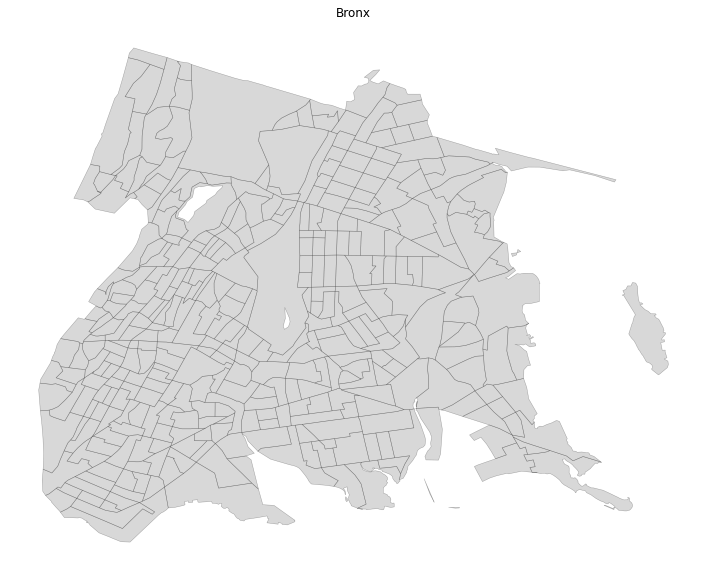

In [131]:
# check plot

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BX_trees_cap.plot(ax = ax, alpha = 0.3, edgecolor = 'black', linewidth = 0.5, color = 'gray')

ax.axis('off')
ax.set(title = 'Bronx')

plt.savefig("maps/Bronx/Bronx_Trees-per-Capita_moran.pdf")

In [75]:
# first - drop cells containing Null values (cells containing zero points) - or code will not work
BX_trees_cap = BX_trees_cap.dropna(subset = ['trees_per_capita'])

In [76]:
# re-check for NaN values
BX_trees_cap['trees_per_capita'].isnull().values.any()

False

In [77]:
# drop trees per capita with 0
BX_trees_cap = BX_trees_cap.query("trees_per_capita > 0")

In [78]:
# check min value
BX_trees_cap['trees_per_capita'].min()

0.006747638326585695

In [79]:
# check max value
BX_trees_cap['trees_per_capita'].max()

170.0

In [81]:
w_BX = weights.Queen.from_dataframe(BX_trees_cap)

In [83]:
w_BX = weights.KNN.from_dataframe(BX_trees_cap, k=1)

In [ ]:
w_BX = weights.attach_islands(w_BX, w_knn_BX)

In [84]:
# row standardize weights
w_BX.transform = 'R'

## Spatial Autocorrelation - Local Moran's I
### *removed all census tracts with 0 trees per capita*

In [85]:
# on trees per capita
local_moran_BX = esda.moran.Moran_Local(BX_trees_cap['trees_per_capita'], w_BX)

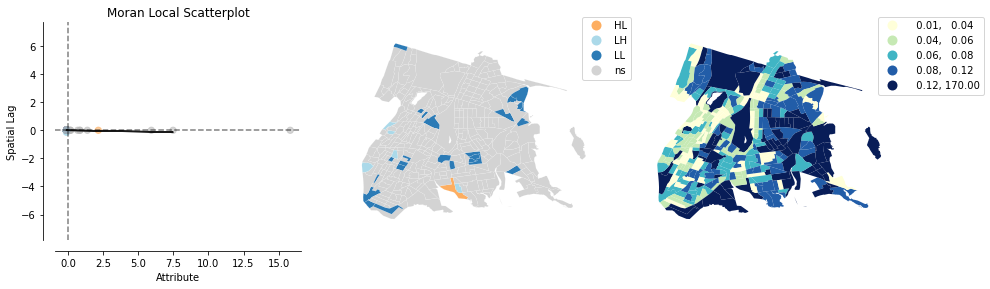

In [86]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_BX, BX_trees_cap,'trees_per_capita', p = 0.05 );

plt.savefig("maps/Bronx/Broonx_Trees-per-Capita_moran.pdf")

In [87]:
# get clusters and outliers - adding columns to the DF

BX_trees_cap['local_moran_Is'] = local_moran_BX.Is
BX_trees_cap['local_moran_p_value'] = local_moran_BX.p_sim
BX_trees_cap['local_moran_quadrant'] = local_moran_BX.q

In [88]:
# get statisically significant clusters and outliers

alpha = 0.05
hotspots_BX = BX_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_BX = BX_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_BX = BX_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_BX = BX_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

/Users/djferrera/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


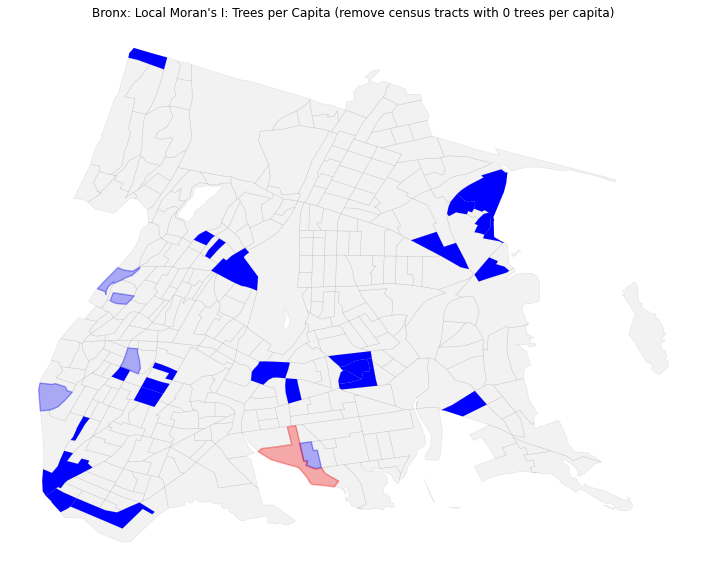

In [89]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BX_trees_cap.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
BX_trees_cap.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_BX.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_BX.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_BX.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_BX.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Bronx: Local Moran's I: Trees per Capita (remove census tracts with 0 trees per capita)")

plt.savefig("maps/Bronx/Bronx_Trees-per-Capita.pdf")

### *investigate the numbers*

In [90]:
# look at smallest values
BX_trees_cap['trees_per_capita'].nsmallest(n=10)

2085    0.006748
1639    0.009070
1232    0.013722
1829    0.014743
1724    0.014955
1636    0.017568
1264    0.018855
143     0.020068
2132    0.020349
1872    0.022021
Name: trees_per_capita, dtype: float64

In [91]:
# look at largest values
BX_trees_cap['trees_per_capita'].nlargest(n=10)

1813    170.000000
215      81.000000
1679     64.500000
407      24.200000
2039     15.875000
1158     10.333333
2242     10.161290
1830      8.529412
1117      3.250000
1811      2.963964
Name: trees_per_capita, dtype: float64

In [92]:
# lowest 1% of data
print(BX_trees_cap['trees_per_capita'].quantile(q = 0.01))

0.014855441460533617


In [93]:
# lowest 5% of data
print(BX_trees_cap['trees_per_capita'].quantile(q = 0.05))

0.030352642062970468


In [94]:
# lowest 10% of data
print(BX_trees_cap['trees_per_capita'].quantile(q = 0.10))

0.03770980537616172


In [95]:
# lowest 20% of data
print(BX_trees_cap['trees_per_capita'].quantile(q = 0.20))

0.04350444927103656


In [96]:
# highest 1% of data
print(BX_trees_cap['trees_per_capita'].quantile(q = 0.99))

19.787749999999754


In [97]:
# highest 5% of data
print(BX_trees_cap['trees_per_capita'].quantile(q = 0.95))

0.2488179640851796


In [98]:
# highest 10% of data
print(BX_trees_cap['trees_per_capita'].quantile(q = 0.90))

0.1650950172728305


In [99]:
# highest 20% of data
print(BX_trees_cap['trees_per_capita'].quantile(q = 0.80))

0.12022303998705552


## Spatial Autocorrelation - Local Moran's I - limited
### *removed all census tracts with less than 0.03 and more than 10  trees per capita*

In [100]:
# limit the range
BX_trees_cap_limit = BX_trees_cap.query("trees_per_capita > 0.03 & trees_per_capita < 10")

In [102]:
w_BX2 = weights.Queen.from_dataframe(BX_trees_cap_limit)

In [104]:
w_BX2 = weights.KNN.from_dataframe(BX_trees_cap_limit, k=1)

In [ ]:
w_BX2 = weights.attach_islands(w_BX2, w_knn_BX2)

In [105]:
# row standardize weights
w_BX2.transform = 'R'

In [106]:
# on trees per capita
local_moran_BX2 = esda.moran.Moran_Local(BX_trees_cap_limit['trees_per_capita'], w_BX2)

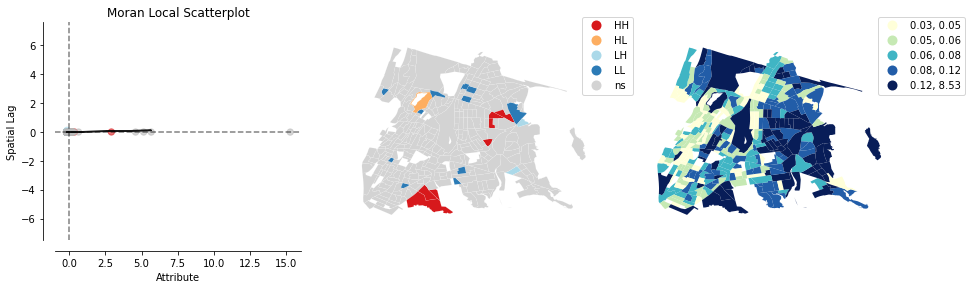

In [107]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_BX2, BX_trees_cap_limit,'trees_per_capita', p = 0.05 );

plt.savefig("maps/Bronx/Broonx_Trees-per-Capita_limited_moran.pdf")

In [109]:
# get clusters and outliers
BX_trees_cap_limit['local_moran_Is'] = local_moran_BX2.Is
BX_trees_cap_limit['local_moran_p_value'] = local_moran_BX2.p_sim
BX_trees_cap_limit['local_moran_quadrant'] = local_moran_BX2.q

In [110]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_BX2 = BX_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_BX2 = BX_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_BX2 = BX_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_BX2 = BX_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

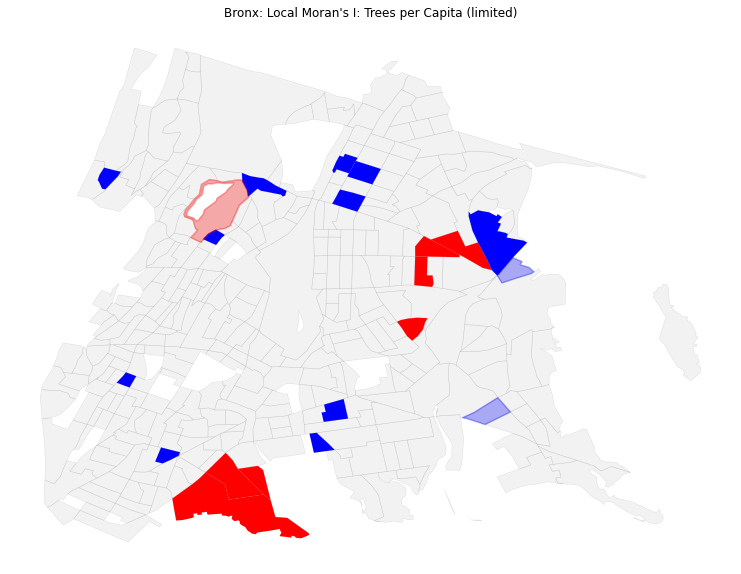

In [111]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BX_trees_cap_limit.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
BX_trees_cap_limit.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_BX2.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_BX2.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_BX2.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_BX2.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Bronx: Local Moran's I: Trees per Capita (limited)")

plt.savefig("maps/Bronx/Bronx_Trees-per-Capita_limited.pdf")

## Spatial Autocorrelation - Local Moran's I - more limited
### *removed all census tracts with less than 0.04 and more than 0.5  trees per capita*

In [112]:
# limit the range
BX_trees_cap_limit_more = BX_trees_cap.query("trees_per_capita > 0.04 & trees_per_capita < 0.5")

In [114]:
w_BX3 = weights.Queen.from_dataframe(BX_trees_cap_limit_more)

In [116]:
w_BX3 = weights.KNN.from_dataframe(BX_trees_cap_limit_more, k=1)

In [ ]:
w_BX3 = weights.attach_islands(w_BX3, w_knn_BX3)

In [117]:
# row standardize weights
w_BX3.transform = 'R'

In [118]:
# on trees per capita
local_moran_BX3 = esda.moran.Moran_Local(BX_trees_cap_limit_more['trees_per_capita'], w_BX3)

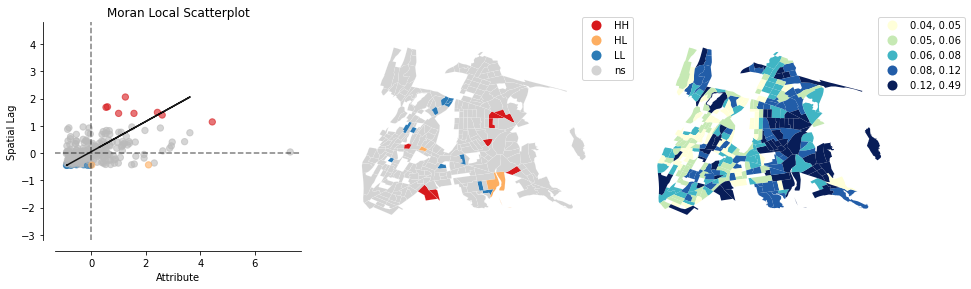

In [119]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_BX3, BX_trees_cap_limit_more,'trees_per_capita', p = 0.05 );

plt.savefig("maps/Bronx/Broonx_Trees-per-Capita_more-limited_moran.pdf")

In [121]:
# get clusters and outliers
BX_trees_cap_limit_more['local_moran_Is'] = local_moran_BX3.Is
BX_trees_cap_limit_more['local_moran_p_value'] = local_moran_BX3.p_sim
BX_trees_cap_limit_more['local_moran_quadrant'] = local_moran_BX3.q

In [122]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_BX3 = BX_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_BX3 = BX_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_BX3 = BX_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_BX3 = BX_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

/Users/djferrera/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


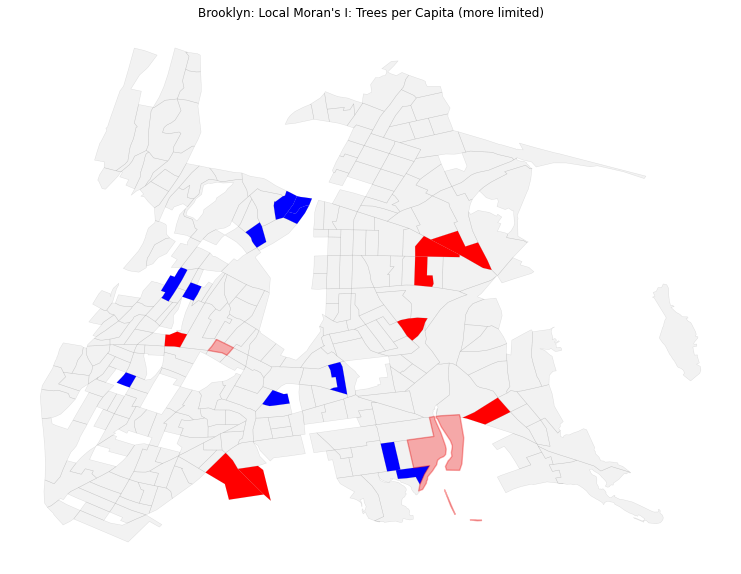

In [123]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BX_trees_cap_limit_more.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
BX_trees_cap_limit_more.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_BX3.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_BX3.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_BX3.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_BX3.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Brooklyn: Local Moran's I: Trees per Capita (more limited)")

plt.savefig("maps/Bronx/Bronx_Trees-per-Capita_more-limited.pdf")